# Method paper plots

In [132]:
import qnmfits
import numpy as np
import scipy
import corner
import matplotlib.pyplot as plt
from qnmfits.spatial_mapping_functions import * 
from funcs.likelihood_funcs import *
from funcs.CCE import * 
from funcs.kernel_param_funcs import *
from funcs.GP_funcs import *
from funcs.qnm_selecting_funcs import * 
from funcs.utils import * 

In [ ]:
id = "0001"

sim_main = SXS_CCE(id, lev="Lev5", radius="R2")
sim_lower = SXS_CCE(id, lev="Lev4", radius="R2")

# Align waveforms (for noise floor calcs) and put them on the same time grid 

time_shift = get_time_shift(sim_main, sim_lower)
sim_lower.zero_time = -time_shift
sim_lower.time_shift()

new_times = np.arange(sim_main.times[0], sim_main.times[-1], 0.1)
sim_main_interp = sim_interpolator(sim_main, new_times)
sim_lower_interp = sim_interpolator(sim_lower, new_times)

n_max = 7

T = 100

qnm_list = [(2,2,n,1) for n in np.arange(0, n_max+1)] #+ [(3,2,0,1), (4,2,0,1)]
spherical_modes = [(2, 2)]

# Get the true, reference values for mass and spin 

chif_mag_ref = sim_main.chif_mag
Mf_ref = sim_main.Mf

T0s = np.linspace(-25, 100, 65)

INCLUDE_MF = True
INCLUDE_CHIF = True

Determine mass and spin as free parameters for least-squares

In [134]:
def Mf_chif_mismatch(Mf_chif_mag_list, t0, T, spherical_modes):
    Mf, chif_mag = Mf_chif_mag_list
    best_fit = qnmfits.multimode_ringdown_fit(
                sim_main.times, sim_main.h, qnm_list, Mf, chif_mag, t0, t0_method="geq", T=T, spherical_modes=spherical_modes
                )
    return best_fit["mismatch"]

In [135]:
initial_params = (Mf_ref, chif_mag_ref)

Mf_RANGE = (Mf_ref*0.5, Mf_ref*1.5)
chif_mag_RANGE = (0.1, 0.99)
bounds = (Mf_RANGE, chif_mag_RANGE)

Mfs_chifs = np.zeros((len(T0s), 2))

In [136]:
for i, t0 in enumerate(T0s):

    args = (t0, T, spherical_modes)

    result = minimize(
            Mf_chif_mismatch,
            initial_params,
            args=args,
            method="Nelder-Mead",
            bounds=bounds,
        )

    Mfs_chifs[i] = result.x
    initial_params = result.x

In [ ]:
# Get the main kernel parameters

with open('tuned_params.pkl', 'rb') as f:
    params = pickle.load(f)

tuned_param_dict_main = params[id]

In [ ]:
# Get the white noise kernel parameters 

with open('param_dict_sim_lm_full.pkl', 'rb') as f:
    param_dict_sim_lm = pickle.load(f)

tuning_hyperparams_s = [0.29245605468749936]  # This value was determined in get_kernel_params_alt.ipynb

hyperparam_rule_dict_s = {
    "sigma_max": "multiply",
}

tuned_param_dict_wn = {mode: get_new_params(param_dict_sim_lm[id][mode], tuning_hyperparams_s, hyperparam_rule_dict_s) for mode in param_dict_sim_lm[id]}

Loop over start times, performing a BGP fit and a LS fit

In [ ]:
BGP_uw_mismatch_array = np.zeros((len(T0s)))
BGP_w_mismatch_array = np.zeros((len(T0s)))

ls_uw_mismatch_array = np.zeros((len(T0s)))
ls_w_mismatch_array = np.zeros((len(T0s)))

w_mismatch_noise_floor = np.zeros((len(T0s)))
uw_mismatch_noise_floor = np.zeros((len(T0s)))

ls_amplitudes_array = np.zeros((len(T0s), len(qnm_list)))

amplitudes_array = np.zeros((len(T0s), len(qnm_list)))
amplitudes_10_percentiles = np.zeros((len(T0s), len(qnm_list)))
amplitudes_25_percentiles = np.zeros((len(T0s), len(qnm_list)))
amplitudes_50_percentiles = np.zeros((len(T0s), len(qnm_list)))
amplitudes_75_percentiles = np.zeros((len(T0s), len(qnm_list)))
amplitudes_90_percentiles = np.zeros((len(T0s), len(qnm_list)))

significances_array_main = np.zeros((len(T0s), len(qnm_list)))
significances_array_wn = np.zeros((len(T0s), len(qnm_list)))

for i, t0 in enumerate(T0s):

    print(f"t0 = {t0}")

    Mf = Mfs_chifs[i, 0]
    chif_mag = Mfs_chifs[i, 1]

    BGP_fit = qnm_BGP_fit(
            sim_main.times,
            sim_main.h,
            qnm_list,
            Mf_ref,
            chif_mag_ref,
            t0,
            tuned_param_dict_main,
            kernel_main,
            t0_method="geq",
            T=T,
            spherical_modes=spherical_modes,
            include_chif=INCLUDE_CHIF,
            include_Mf=INCLUDE_MF,
        )
    
    BGP_fit_wn = qnm_BGP_fit_lite(
            sim_main.times,
            sim_main.h,
            qnm_list,
            Mf_ref,
            chif_mag_ref,
            t0,
            tuned_param_dict_wn,
            kernel_s,
            t0_method="geq",
            T=T,
            spherical_modes=spherical_modes,
            include_chif=INCLUDE_CHIF,
            include_Mf=INCLUDE_MF,
        )
    
    ls_fit = qnmfits.multimode_ringdown_fit(
                        sim_main.times,
                        sim_main.h,
                        qnm_list,
                        Mf,
                        chif_mag,
                        t0,
                        T=T,
                        spherical_modes=spherical_modes,
                    )

    BGP_uw_mismatch_array[i] = BGP_fit['unweighted_mismatch']
    BGP_w_mismatch_array[i] = BGP_fit['weighted_mismatch']

    ls_uw_mismatch_array[i] = unweighted_mismatch(ls_fit['model'], ls_fit['data'])
    ls_w_mismatch_array[i] = weighted_mismatch(ls_fit['model'], ls_fit['data'], BGP_fit['inv_noise_covariance'])

    ls_amplitudes_array[i, :] = np.abs(ls_fit['C'])

    amplitudes_array[i, :] = BGP_fit['mean_abs_amplitude']
    
    amplitudes_10_percentiles[i, :], \
        amplitudes_25_percentiles[i, :], \
            amplitudes_50_percentiles[i, :], \
                amplitudes_75_percentiles[i, :], \
                    amplitudes_90_percentiles[i, :] = BGP_fit['abs_amplitude_percentiles']

    significances = get_significance_list(qnm_list, BGP_fit['mean'], BGP_fit['fisher_matrix'])
    significances_array_main[i, :] = significances 

    significances_wn = get_significance_list(qnm_list, BGP_fit_wn['mean'], BGP_fit_wn['fisher_matrix'])
    significances_array_wn[i, :] = significances_wn

    mm_mask = (sim_main_interp.times >= t0 - 1e-9) & (sim_main_interp.times < t0+T - 1e-9)
    mm_times = sim_main_interp.times[mm_mask]
    main_data = {(2, 2): sim_main_interp.h[(2, 2)][mm_mask]}
    lower_data = {(2, 2): sim_lower_interp.h[(2, 2)][mm_mask]}

    uw_mismatch_noise_floor[i] = unweighted_mismatch(main_data, lower_data)
    w_mismatch_noise_floor[i] = weighted_mismatch(main_data, lower_data, BGP_fit['inv_noise_covariance'])

t0 = -25.0
t0 = -23.046875
t0 = -21.09375
t0 = -19.140625
t0 = -17.1875
t0 = -15.234375
t0 = -13.28125


# Mismatch

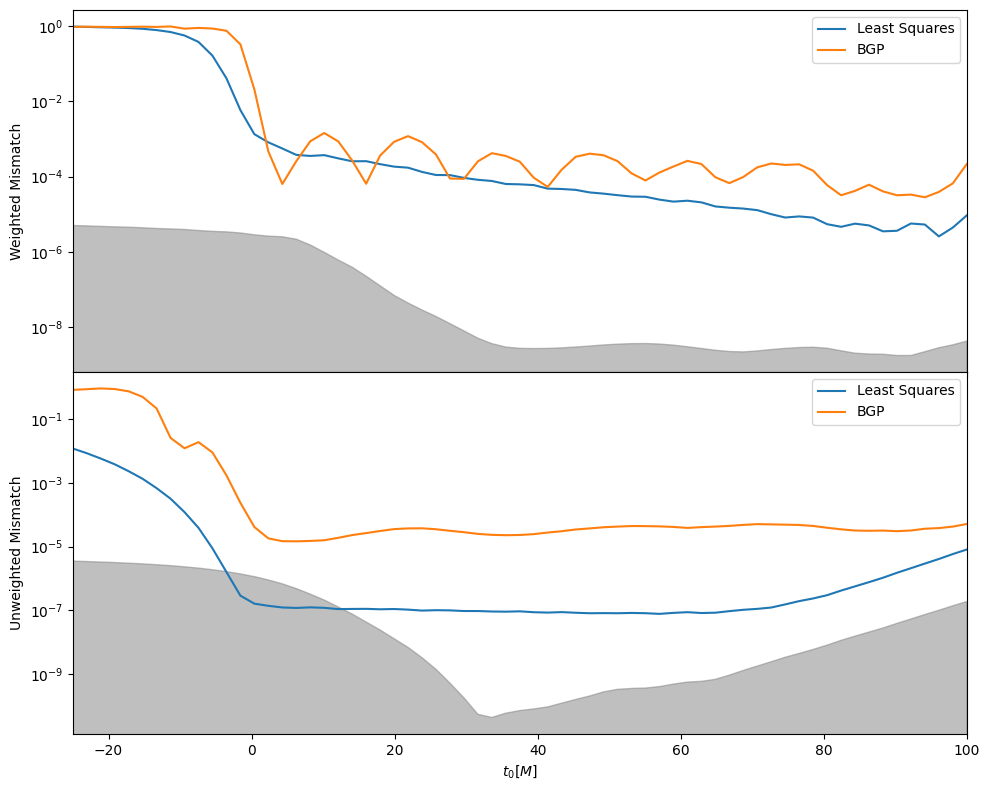

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'hspace': 0})

ax1.plot(T0s, ls_w_mismatch_array, label="Least Squares")
ax1.plot(T0s, BGP_w_mismatch_array, label="BGP")
ax1.fill_between(T0s, 0, w_mismatch_noise_floor, color="grey", alpha=0.5)
ax1.set_ylabel("Weighted Mismatch")
ax1.set_yscale("log")
ax1.legend()

ax2.plot(T0s, ls_uw_mismatch_array, label="Least Squares")
ax2.plot(T0s, BGP_uw_mismatch_array, label="BGP")
ax2.fill_between(T0s, 0, uw_mismatch_noise_floor, color="grey", alpha=0.5)
ax2.set_xlabel("$t_0 [M]$")
ax2.set_ylabel("Unweighted Mismatch")
ax2.set_yscale("log")
ax2.legend()

ax1.set_xlim(T0s[0], T0s[-1])
ax2.set_xlim(T0s[0], T0s[-1])

plt.tight_layout()
plt.show()

# Amplitudes

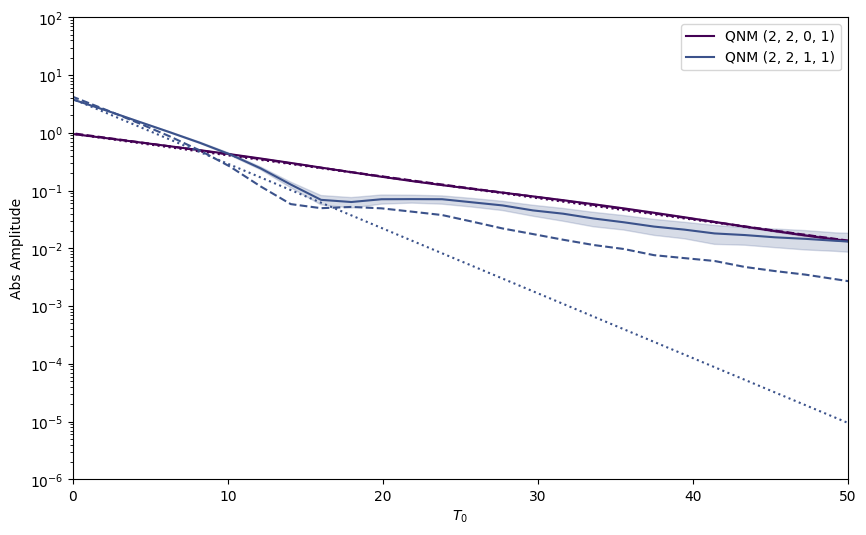

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

for i, qnm in enumerate(qnm_list):
    if i <= 1:
        decay_time = qnmfits.qnm.omega_list([qnm], chif_mag_ref, Mf_ref)[0].imag
        closest_time_index = np.argmin(np.abs(T0s - 0))
        C_tau = amplitudes_array[closest_time_index, i] * np.exp(-decay_time * (T0s[closest_time_index] - T0s))
        ax.plot(T0s, amplitudes_50_percentiles[:, i], label=f"QNM {qnm}", color=colors[i])
        ax.plot(T0s, ls_amplitudes_array[:, i], linestyle='--', color=colors[i])
        ax.plot(T0s, C_tau, linestyle=':', color=colors[i])
        ax.fill_between(
            T0s,
            amplitudes_25_percentiles[:, i],
            amplitudes_75_percentiles[:, i],
            alpha=0.2,
            color=colors[i],
        )

ax.set_xlim(0, 50)
ax.set_ylim(1e-6, 1e2)
ax.set_xlabel("$T_0$")
ax.set_ylabel("Abs Amplitude")
ax.set_yscale("log")
ax.legend()
plt.show()

# Significance

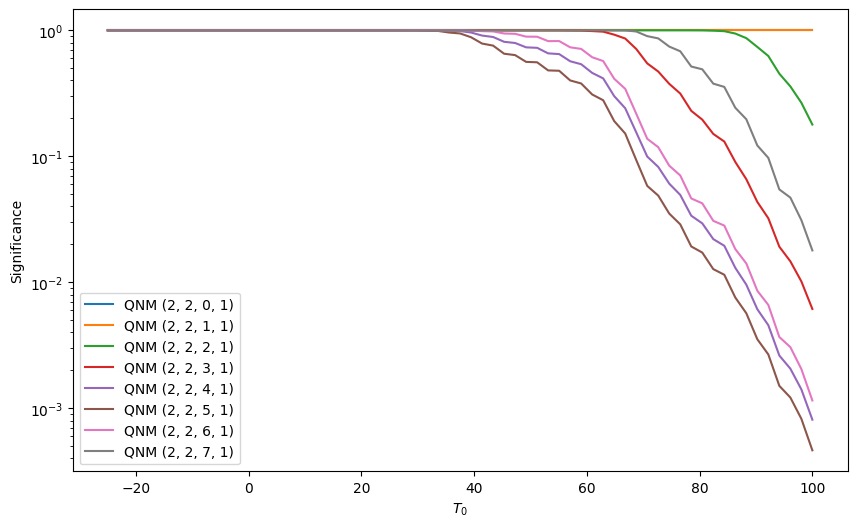

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, qnm in enumerate(qnm_list):
    ax.plot(T0s, significances_array_main[:, i], label=f"QNM {qnm}")
    ax.plot(T0s, significances_array_wn[:, i], linestyle='--', label=f"QNM {qnm} (WN)")

ax.set_xlabel("$T_0$")
ax.set_ylabel("Significance")
ax.set_yscale("log")
ax.legend()
plt.show()

# Corner Plots

In [ ]:
T0_choice = 20

Mf = Mfs_chifs[np.argmin(np.abs(T0s - T0_choice))][0]
chif_mag = Mfs_chifs[np.argmin(np.abs(T0s - T0_choice))][1]

BGP_fit = qnm_BGP_fit(
            sim_main.times,
            sim_main.h,
            qnm_list,
            Mf_ref,
            chif_mag_ref,
            T0s[np.argmin(np.abs(T0s - T0_choice))],
            tuned_param_dict_main,
            kernel_main,
            t0_method="geq",
            T=T,
            spherical_modes=spherical_modes,
            include_chif=INCLUDE_CHIF,
            include_Mf=INCLUDE_MF,
        )


BGP_fit_wn = qnm_BGP_fit(
            sim_main.times,
            sim_main.h,
            qnm_list,
            Mf_ref,
            chif_mag_ref,
            T0s[np.argmin(np.abs(T0s - T0_choice))],
            tuned_param_dict_wn, 
            kernel_s,
            t0_method="geq",
            T=T,
            spherical_modes=spherical_modes,
            include_chif=INCLUDE_CHIF,
            include_Mf=INCLUDE_MF,
        )
    

ls_fit = qnmfits.multimode_ringdown_fit(
                    sim_main.times,
                    sim_main.h,
                    qnm_list,
                    Mf,
                    chif_mag,
                    T0s[np.argmin(np.abs(T0s - T0_choice))],
                    T=T,
                    spherical_modes=spherical_modes,
                )

In [ ]:
ref_params = []
for re_c, im_c in zip(np.real(ls_fit["C"]), np.imag(ls_fit["C"])):
    ref_params.append(re_c)
    ref_params.append(im_c)

In [ ]:
param_list = [qnm for qnm in qnm_list for _ in range(2)]
parameter_choice = [(2,2,0,1), (2,2,1,1)]

indices = [i for i, param in enumerate(param_list) if param in parameter_choice]

marginal_mean_main, marginal_fisher_main = marginalise(parameter_choice, param_list, BGP_fit["mean"], BGP_fit["fisher_matrix"])
marginal_covariance_main = get_inverse(marginal_fisher_main)    

marginal_mean_wn, marginal_fisher_wn = marginalise(parameter_choice, param_list, BGP_fit_wn["mean"], BGP_fit_wn["fisher_matrix"])
marginal_covariance_wn = get_inverse(marginal_fisher_wn)

In [ ]:
samples_main = scipy.stats.multivariate_normal(
    marginal_mean_main, marginal_covariance_main, allow_singular=True
).rvs(size=10000)

samples_wn = scipy.stats.multivariate_normal(
    marginal_mean_wn, marginal_covariance_wn, allow_singular=True
).rvs(size=10000)

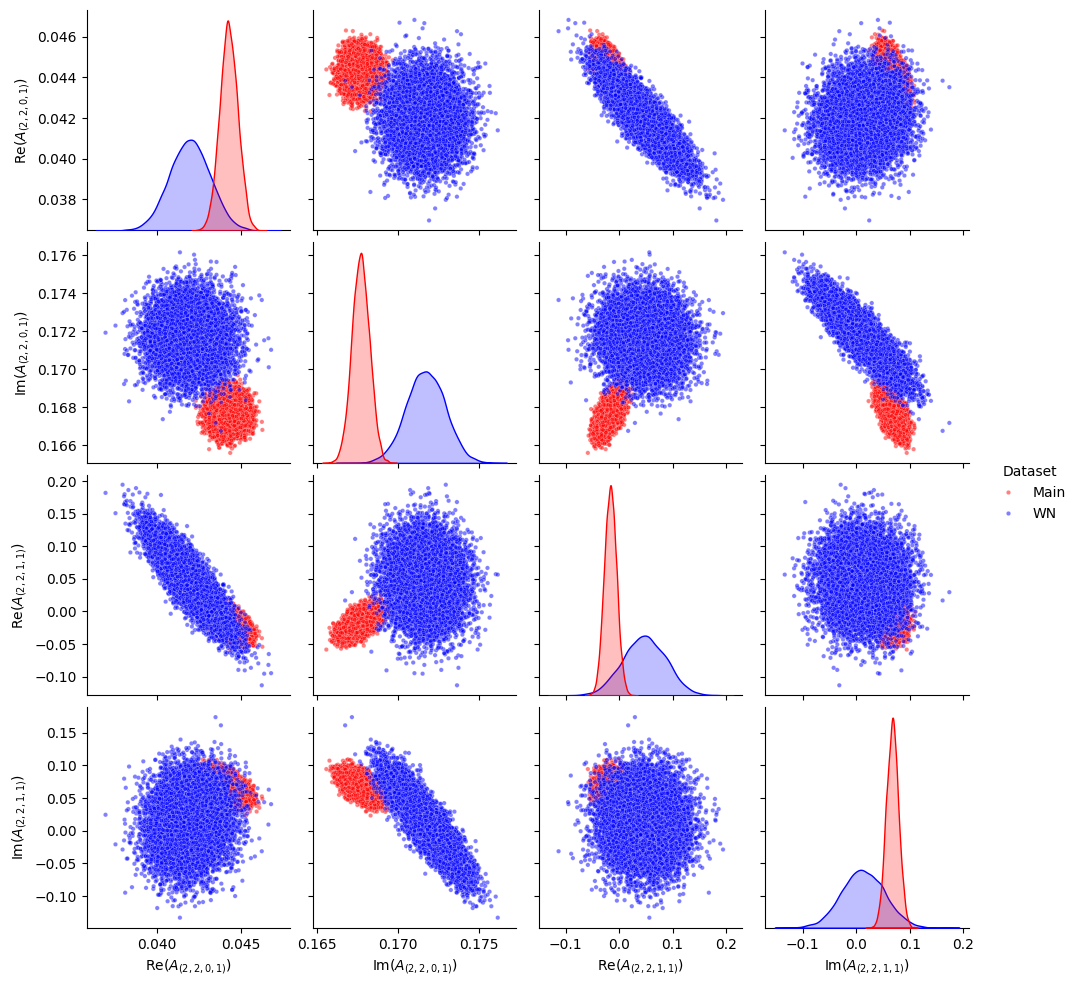

In [ ]:
import seaborn as sns
import pandas as pd

labels = [
    rf"$\mathrm{{Re}}(A_{{{param}}})$" if i % 2 == 0 else rf"$\mathrm{{Im}}(A_{{{param}}})$"
    for param in parameter_choice
    for i in range(2)
]

# Convert samples_main and samples_wn into DataFrames for seaborn
df_main = pd.DataFrame(samples_main, columns=labels)
df_wn = pd.DataFrame(samples_wn, columns=labels)

# Add a column to distinguish the datasets
df_main['Dataset'] = 'Main'
df_wn['Dataset'] = 'WN'

# Combine the datasets
df_combined = pd.concat([df_main, df_wn])
# Create the pairplot with contours and true values
pairplot = sns.pairplot(
    df_combined,
    hue='Dataset',
    diag_kind='kde',
    palette={'Main': 'red', 'WN': 'blue'},
    plot_kws={'alpha': 0.5, 's': 10},  # Adjust point size with 's'
)

true_vals = [ref_params[i] for i in indices]


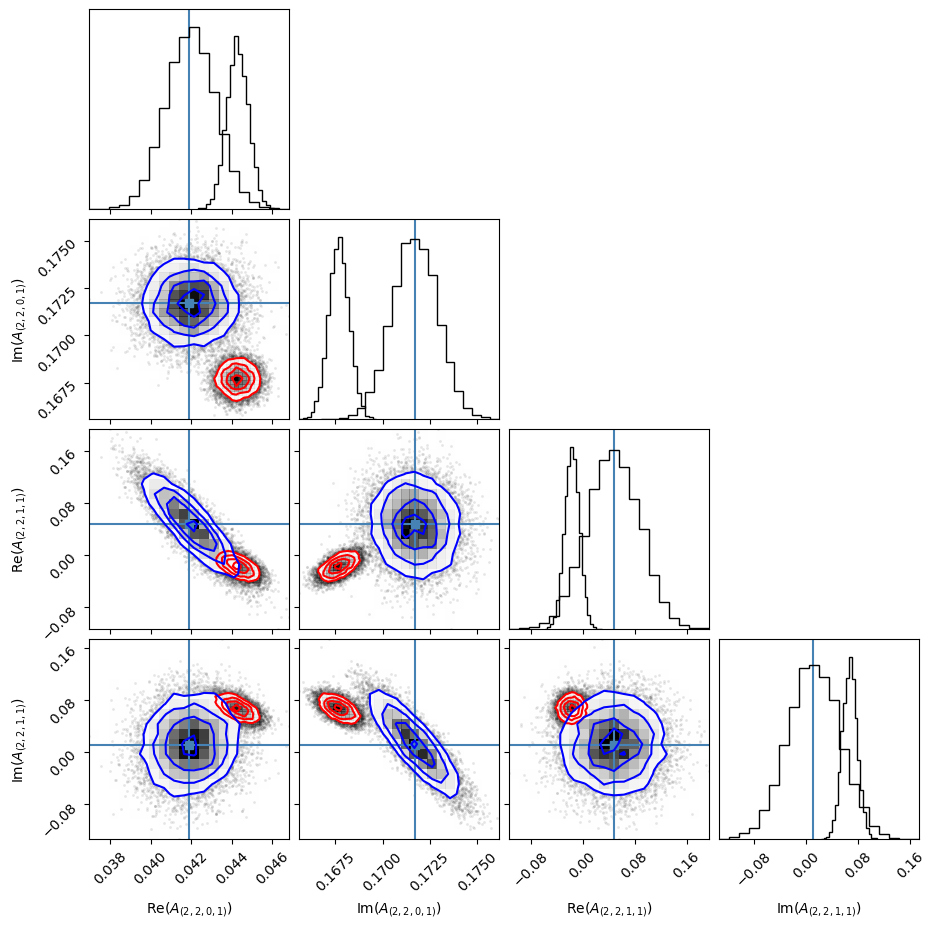

In [ ]:
labels = [
    rf"$\mathrm{{Re}}(A_{{{param}}})$" if i % 2 == 0 else rf"$\mathrm{{Im}}(A_{{{param}}})$"
    for param in parameter_choice
    for i in range(2)
]

# Use seaborn to create the corner plot
figure = corner.corner(
    samples_main,
    truths=[ref_params[i] for i in indices],
    labels=labels,
    colors='red',
    plot_contours=True,
    contour_kwargs={"colors": "red"},
)

fgiure2 = corner.corner(
    samples_wn,
    fig=figure,
    plot_contours=True,
    contour_kwargs={"colors": "blue"},
)


In [ ]:
param_list = [qnm for qnm in qnm_list for _ in range(2)] + ["chif"] + ["Mf"]
ref_params_full = ref_params + [chif_mag, Mf] # Note that we do not use the reference values of chif and Mf here, but the minimized ones 
parameter_choice = ["chif", "Mf"]

indices_mini = [i for i, param in enumerate(param_list) if param in parameter_choice]

marginal_mean_main, marginal_fisher_main = marginalise(parameter_choice, param_list, BGP_fit['mean'], BGP_fit['fisher_matrix'])
marginal_covariance_main = get_inverse(marginal_fisher_main)    

marginal_mean_wn, marginal_fisher_wn = marginalise(parameter_choice, param_list, BGP_fit_wn['mean'], BGP_fit_wn['fisher_matrix'])
marginal_covariance_wn = get_inverse(marginal_fisher_wn)

In [ ]:
samples_mini = scipy.stats.multivariate_normal(
    marginal_mean_main, marginal_covariance_main, allow_singular=True
).rvs(size=10000)

samples_wn_mini = scipy.stats.multivariate_normal(
    marginal_mean_wn, marginal_covariance_wn, allow_singular=True
).rvs(size=10000)

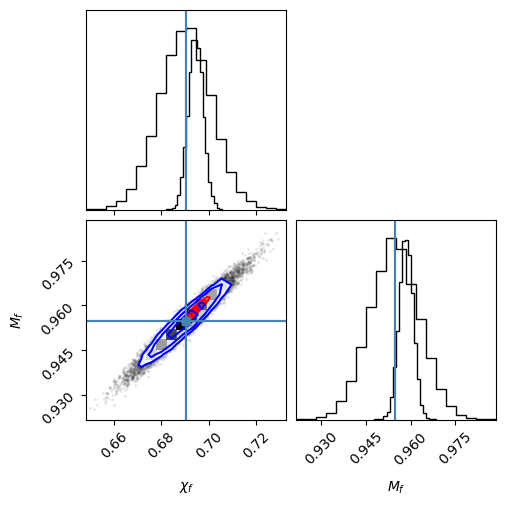

In [ ]:
labels = [
    r"$\chi_f$",
    r"$M_f$",
]
figure = corner.corner(
    samples_mini,
    truths=[ref_params_full[i] for i in indices_mini],
    labels=labels,
    plot_contours=True,
    contour_kwargs={"colors": "red"},
)

figure2 = corner.corner(
    samples_wn_mini,
    fig=figure,
    truths=[ref_params_full[i] for i in indices_mini],
    labels=labels,
    plot_contours=True,
    contour_kwargs={"colors": "blue"},
)